## NLP stuff with Spotify User Reviews

Here we load, preprocess and explore Spotify user reviews to learn NLP preprocessing methods and gain first insights into the dataset.

In [31]:
## Import general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [32]:
## Read data
data_in = pd.read_csv("../data/raw/spotify_review_kaggle.csv")

In [33]:
## Check Data
data_in.head(10)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


In [43]:
## Sample some reviews
data_in["Review"].sample(20)

12588    Unable to add multiple songs to queue while li...
58071    Fantastic App that understands that the right ...
11939    Easy to get around app but music to add ratio ...
50667    Horrible do not get! It was ok at first but af...
2151     It's a good app but when I tried to play my ow...
45938    I love using Spotify, there are literally thou...
13030    Spotify used to be great but recently the app ...
55693    Awesome 👍💯 I love this app really much it is j...
9850     App frequently crashes and loses control on my...
14526    I love Spotify and have been using it for a fe...
25249    I like Spotify I listened to my 1st NorWegIan ...
46900    I loved this app until it locked me out while ...
50307    Spotify is great. Even if you dont pay for pre...
12295    Very good. I have access to any kind of music ...
27552    Was great. Now has a bug where the player won'...
48586    The app constantly has to be set to online mod...
31154    I'm having the same problem that many other re.

In [44]:
## Remove duplicates
print("Before dropping duplicates: ", len(data_in))
data = data_in.drop_duplicates(subset="Review")
print("After dropping duplicates: ", len(data))


Before dropping duplicates:  61594
After dropping duplicates:  61356


In [45]:
## Drop unused cols
data = data[["Review", "Rating"]]
data.head(5)

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [46]:
## Ad col for reviews length
data["Length"] = data["Review"].str.split(" ").str.len()
data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",5,21
1,Please ignore previous negative rating. This a...,5,15
2,"This pop-up ""Get the best Spotify experience o...",4,19
3,Really buggy and terrible to use as of recently,1,9
4,Dear Spotify why do I get songs that I didn't ...,1,21


In [53]:
## Check shortest reviews
data.sort_values("Length").head(30)

,Review,Rating,Length
30670,"Powerful,Spirit-touching songs",5,2
24628,Easy-to-use software,5,2
30894,Great for podcasting,5,3
5992,Good song play!,4,3
17546,Very good.Good songs.,5,3
5939,Totally awesome program,5,3
17688,Lot of advertising,1,3
17706,Too manny ads,2,3
5935,Great music app!,4,3
5899,too many advertisements,1,3


In [48]:
## Check longest reviews
data.sort_values("Length").tail(20)


,Review,Rating,Length
21354,so i love spotify but as you see there is only...,4,112
13407,This app sucks because it adds song I don't wa...,1,112
45809,This app is like when u have to write a 1000 w...,4,113
12793,Hmm I don't know how much it meansJim I have R...,1,114
57928,"Spotify, a MUSIC STREAMING SERVICE chose Joe R...",1,119
12328,The app on a watch needs a lot of work. I down...,1,120
22771,So after the new update the app is still glitc...,1,121
58168,I clicked on the $0.99 for three months promot...,1,125
54164,"I love spotify, but now there seems to be a gl...",1,126
33014,Being a premium user for years I can say that ...,2,137


<Figure size 1200x600 with 0 Axes>

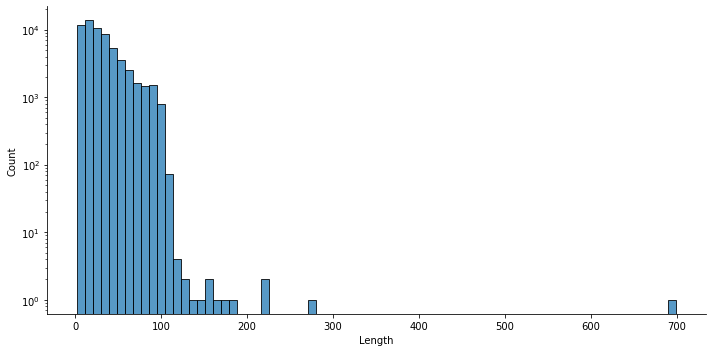

In [51]:
## Plot Review Length as hist
plt.figure(figsize=(4,2), dpi=300)
ax = sns.displot(data["Length"], kind="hist", fill=True, aspect=2, bins=75, log=True);

As we can see, most reviews are no longer than around 120 words; as a next step, we could remove all reviews with more than 150 words.

In [52]:
## Drop long reviews
data = data[data.Length < 150]

print("Number of reviews after trimming: ", len(data))

Number of reviews after trimming:  61346


### Preprocessing

In [54]:
## Import special libraries
import emojis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize as tokenizer

In [55]:
## Get NLTK english stopwords
our_stopwords = set(stopwords.words('english'))
our_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r